# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [148]:
from typing import Iterable, List
import itertools

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import pandas as pd


## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [3]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [222]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        return np.linalg.norm(X @ w - y) ** 2 / len(y)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        res = X @ w
        res -= y
        res = 2 * X.T @ res
        res /= len(y)
        return res
        # return 2 * X.T @ (X @ w - y) / len(y)
    

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [5]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [6]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    weights = np.zeros((n_iterations + 1, len(w_init)))
    weights[0] = w_init
    for i in np.arange(1, n_iterations + 1):
        weights[i] = weights[i - 1] - lr * loss.calc_grad(X, y, weights[i - 1])
    return weights

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [7]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
scaler = StandardScaler()
X = scaler.fit_transform(X)

X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [8]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

49.172842276393936
0.8938301066664964


In [9]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss, ax: plt.axes):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    # plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    # plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

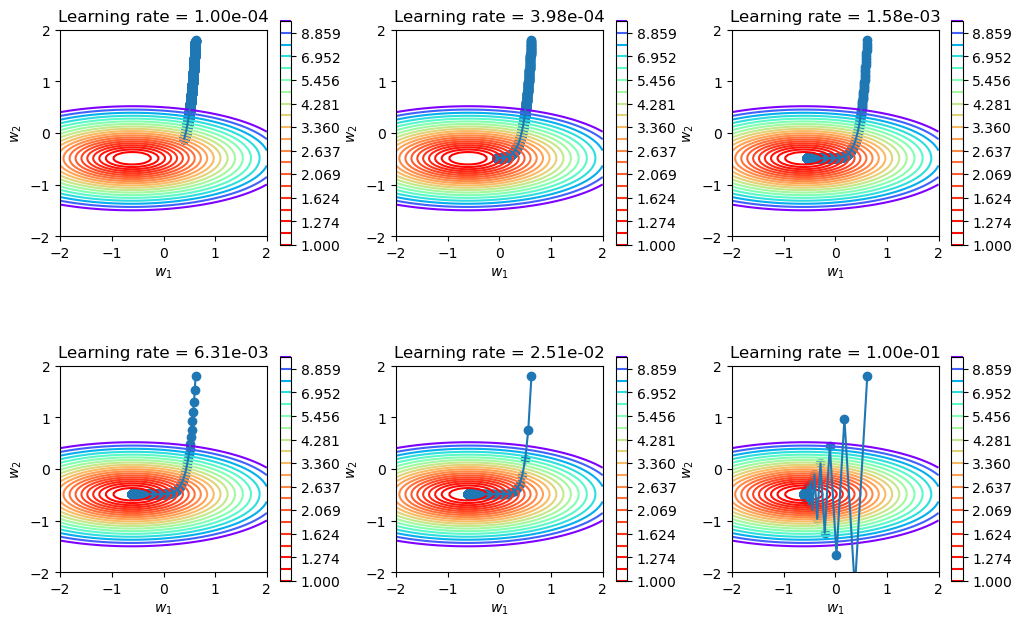

In [10]:
lr_list = np.logspace(-4, -1, 6)

gs = gridspec.GridSpec(2, 3, wspace=0.3)
fig = plt.figure(figsize=(12, 8))

for lr, grd in zip(lr_list,
                   itertools.product([0, 1], [0, 1, 2], repeat=1)):
    w_list = gradient_descent(w_init, X, y, loss, lr, n_iterations=10**3)
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_gd(w_list, X, y, loss, ax)
    plt.title(f"Learning rate = {lr:.2e}")

plt.show()


Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [11]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    weights = np.zeros((n_iterations + 1, len(w_init)))
    weights[0] = w_init

    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    y_batch = y[batch_indices]
    batch = X[batch_indices]

    for i in np.arange(1, n_iterations + 1):
        weights[i] = weights[i - 1] - lr * loss.calc_grad(batch, y_batch, weights[i - 1])
    return weights

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

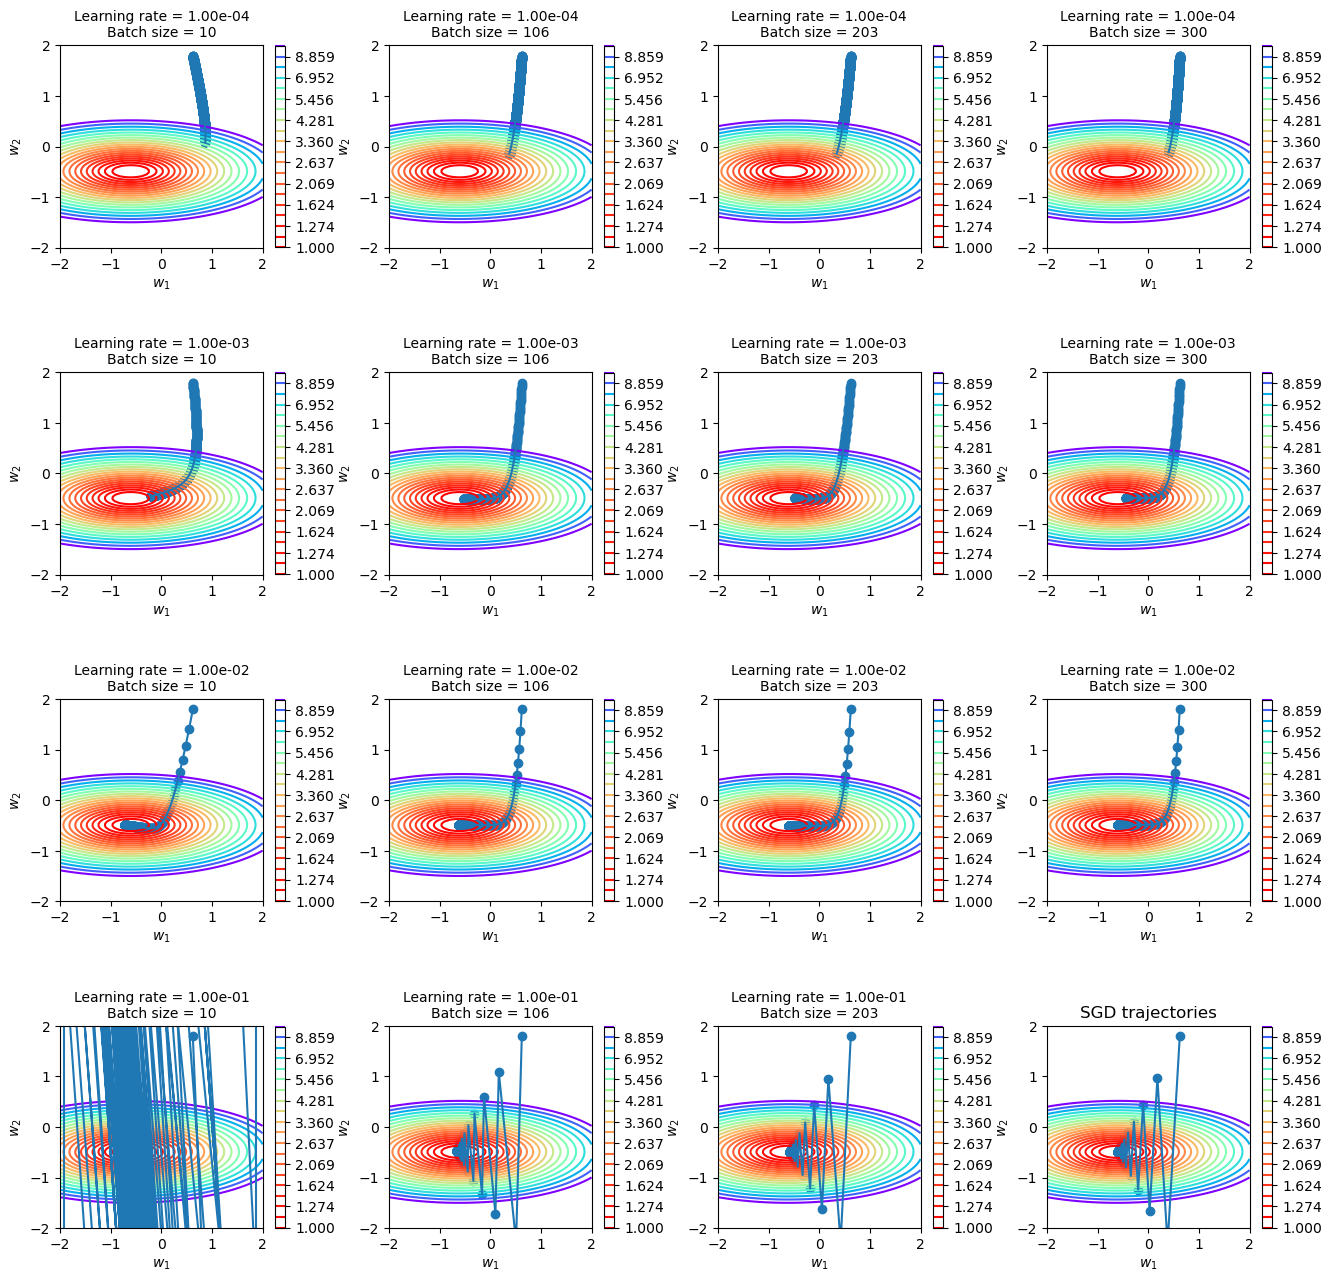

In [12]:
lr_list = np.logspace(-4, -1, 4)
batch_sizes = np.linspace(10, 300, 4)

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(4, 4, figure=fig, hspace=0.3, wspace=0.3)

for params, grd in zip(itertools.product(lr_list, batch_sizes, repeat=1),
                       itertools.product([0, 1, 2, 3], repeat=2)):
    lr, bs = params
    bs = int(bs)
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr,
                                         bs, n_iterations=10**3)
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_gd(w_list, X, y, loss, ax)
    plt.title(f"Learning rate = {lr:.2e}\nBatch size = {bs}",
              size='medium')

plt.title('SGD trajectories')
plt.show()

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [13]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    weights = np.zeros((n_iterations + 1, len(w_init)))
    weights[0] = w_init

    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    y_batch = y[batch_indices]
    batch = X[batch_indices]

    for i in np.arange(1, n_iterations + 1):
        eta = lr * (1 / i)**p
        weights[i] = weights[i - 1] - eta * loss.calc_grad(batch, y_batch, weights[i - 1])
    return weights

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

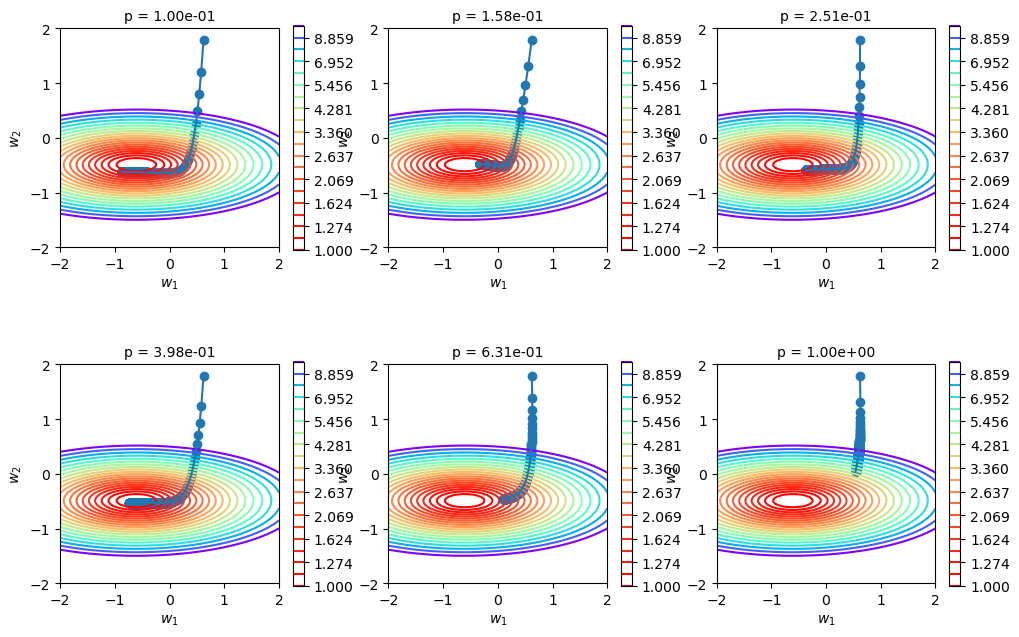

In [14]:
lr = 1e-2
batch_size = 10
p_list = np.logspace(-1, 0, 6)

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3, figure=fig)

for p, grd in zip(p_list,
                  itertools.product([0, 1], [0, 1, 2], repeat=1)):
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr,
                                         batch_size, p, n_iterations=10**3)
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_gd(w_list, X, y, loss, ax)
    plt.title(f"p = {p:.2e}",
              size='medium')

plt.show()

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

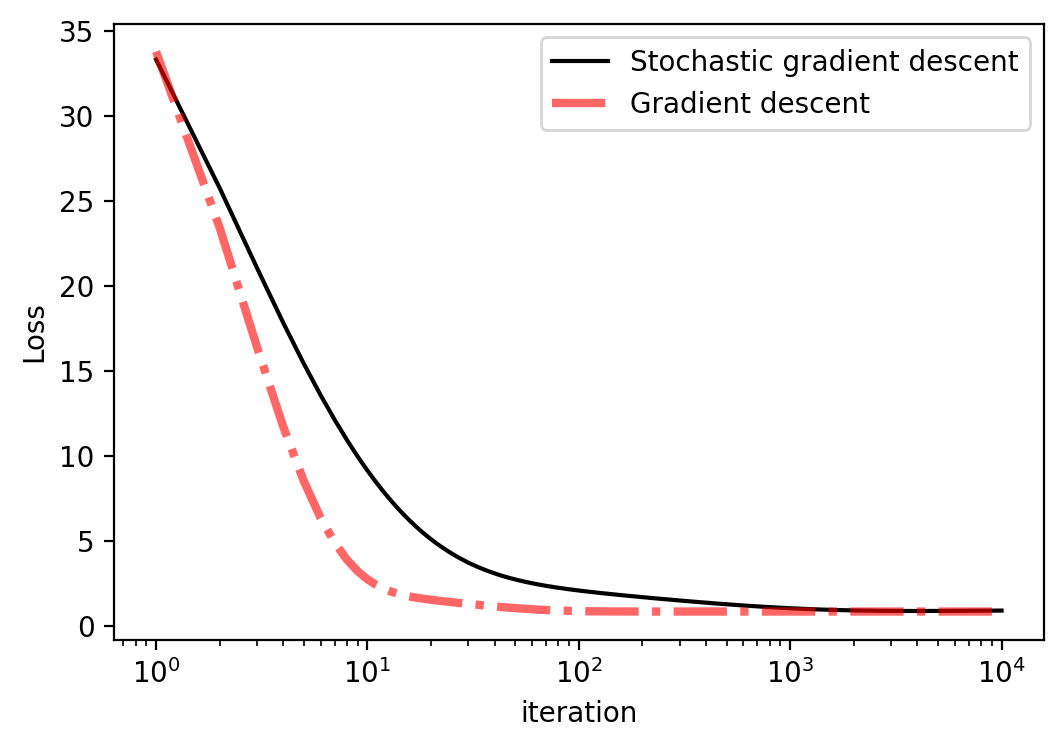

In [15]:
n_iterations = 10**4
w_list = gradient_descent(w_init, X, y, loss, lr, n_iterations=n_iterations)
w_list_stochastic = stochastic_gradient_descent(w_init, X, y, loss, lr,
                                         10, 0.5, n_iterations=n_iterations)
fig = plt.figure(figsize=(6, 4), dpi=200)
plt.plot(range(1, n_iterations + 1),
         [loss.calc_loss(X, y, w_list_stochastic[i]) for i in range(1, n_iterations + 1)],
         label='Stochastic gradient descent', color='black')
plt.plot(range(1, n_iterations + 1),
         [loss.calc_loss(X, y, w_list[i]) for i in range(1, n_iterations + 1)],
         label='Gradient descent', linestyle='-.', color='red', alpha=0.6, lw=3)
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.semilogx()
plt.show()

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [16]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        w_init = np.ones([X.shape[1], ])
        self.w = gradient_descent(w_init, X, y, self.loss, self.lr, n_iterations=10**4)[-1]
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        return X @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [17]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [84]:
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw = X_raw[~X_raw[25].isna()].reset_index()
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)
X_raw

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

**Заполнение пропусков в датайрейме**

In [139]:
# создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values
X_raw.columns = X_raw.columns.astype(str)

# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(
    data=mis_replacer.fit_transform(X_real), columns=X_real.columns
)

# для категориальных — пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)
X_no_mis.head(3)

,index,0,1,9,10,11,12,13,16,18,...,2,3,4,5,6,7,8,14,15,17
0,0.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,1.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,2.0,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi


**One-hot кодирование категориальных признаков**

In [88]:
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
print(f"Data shape: {X_dum.shape}")
X_dum

Data shape: (201, 66)


,index,0,1,9,10,11,12,13,16,18,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,0.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,False,False,False,False,False,False,False,True,False,False
1,1.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,False,False,False,False,False,False,False,True,False,False
2,2.0,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,...,False,False,False,False,False,False,False,True,False,False
3,3.0,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,...,False,False,False,False,False,False,False,True,False,False
4,4.0,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200.0,-1.0,95.0,109.1,188.8,68.9,55.5,2952.0,141.0,3.78,...,False,False,False,False,False,False,False,True,False,False
197,201.0,-1.0,95.0,109.1,188.8,68.8,55.5,3049.0,141.0,3.78,...,False,False,False,False,False,False,False,True,False,False
198,202.0,-1.0,95.0,109.1,188.8,68.9,55.5,3012.0,173.0,3.58,...,False,False,False,False,False,False,False,True,False,False
199,203.0,-1.0,95.0,109.1,188.8,68.9,55.5,3217.0,145.0,3.01,...,False,False,False,False,False,True,False,False,False,False


**Нормализация признаков**

In [225]:
scaler = MinMaxScaler()
X_real_norm_np = scaler.fit_transform(X_dum.drop(['index'], axis=1))
X = pd.DataFrame(data=X_real_norm_np)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Исследование характера зависимости целевой переменной от вещественных признаков**

In [226]:
X_real.shape[1]

16

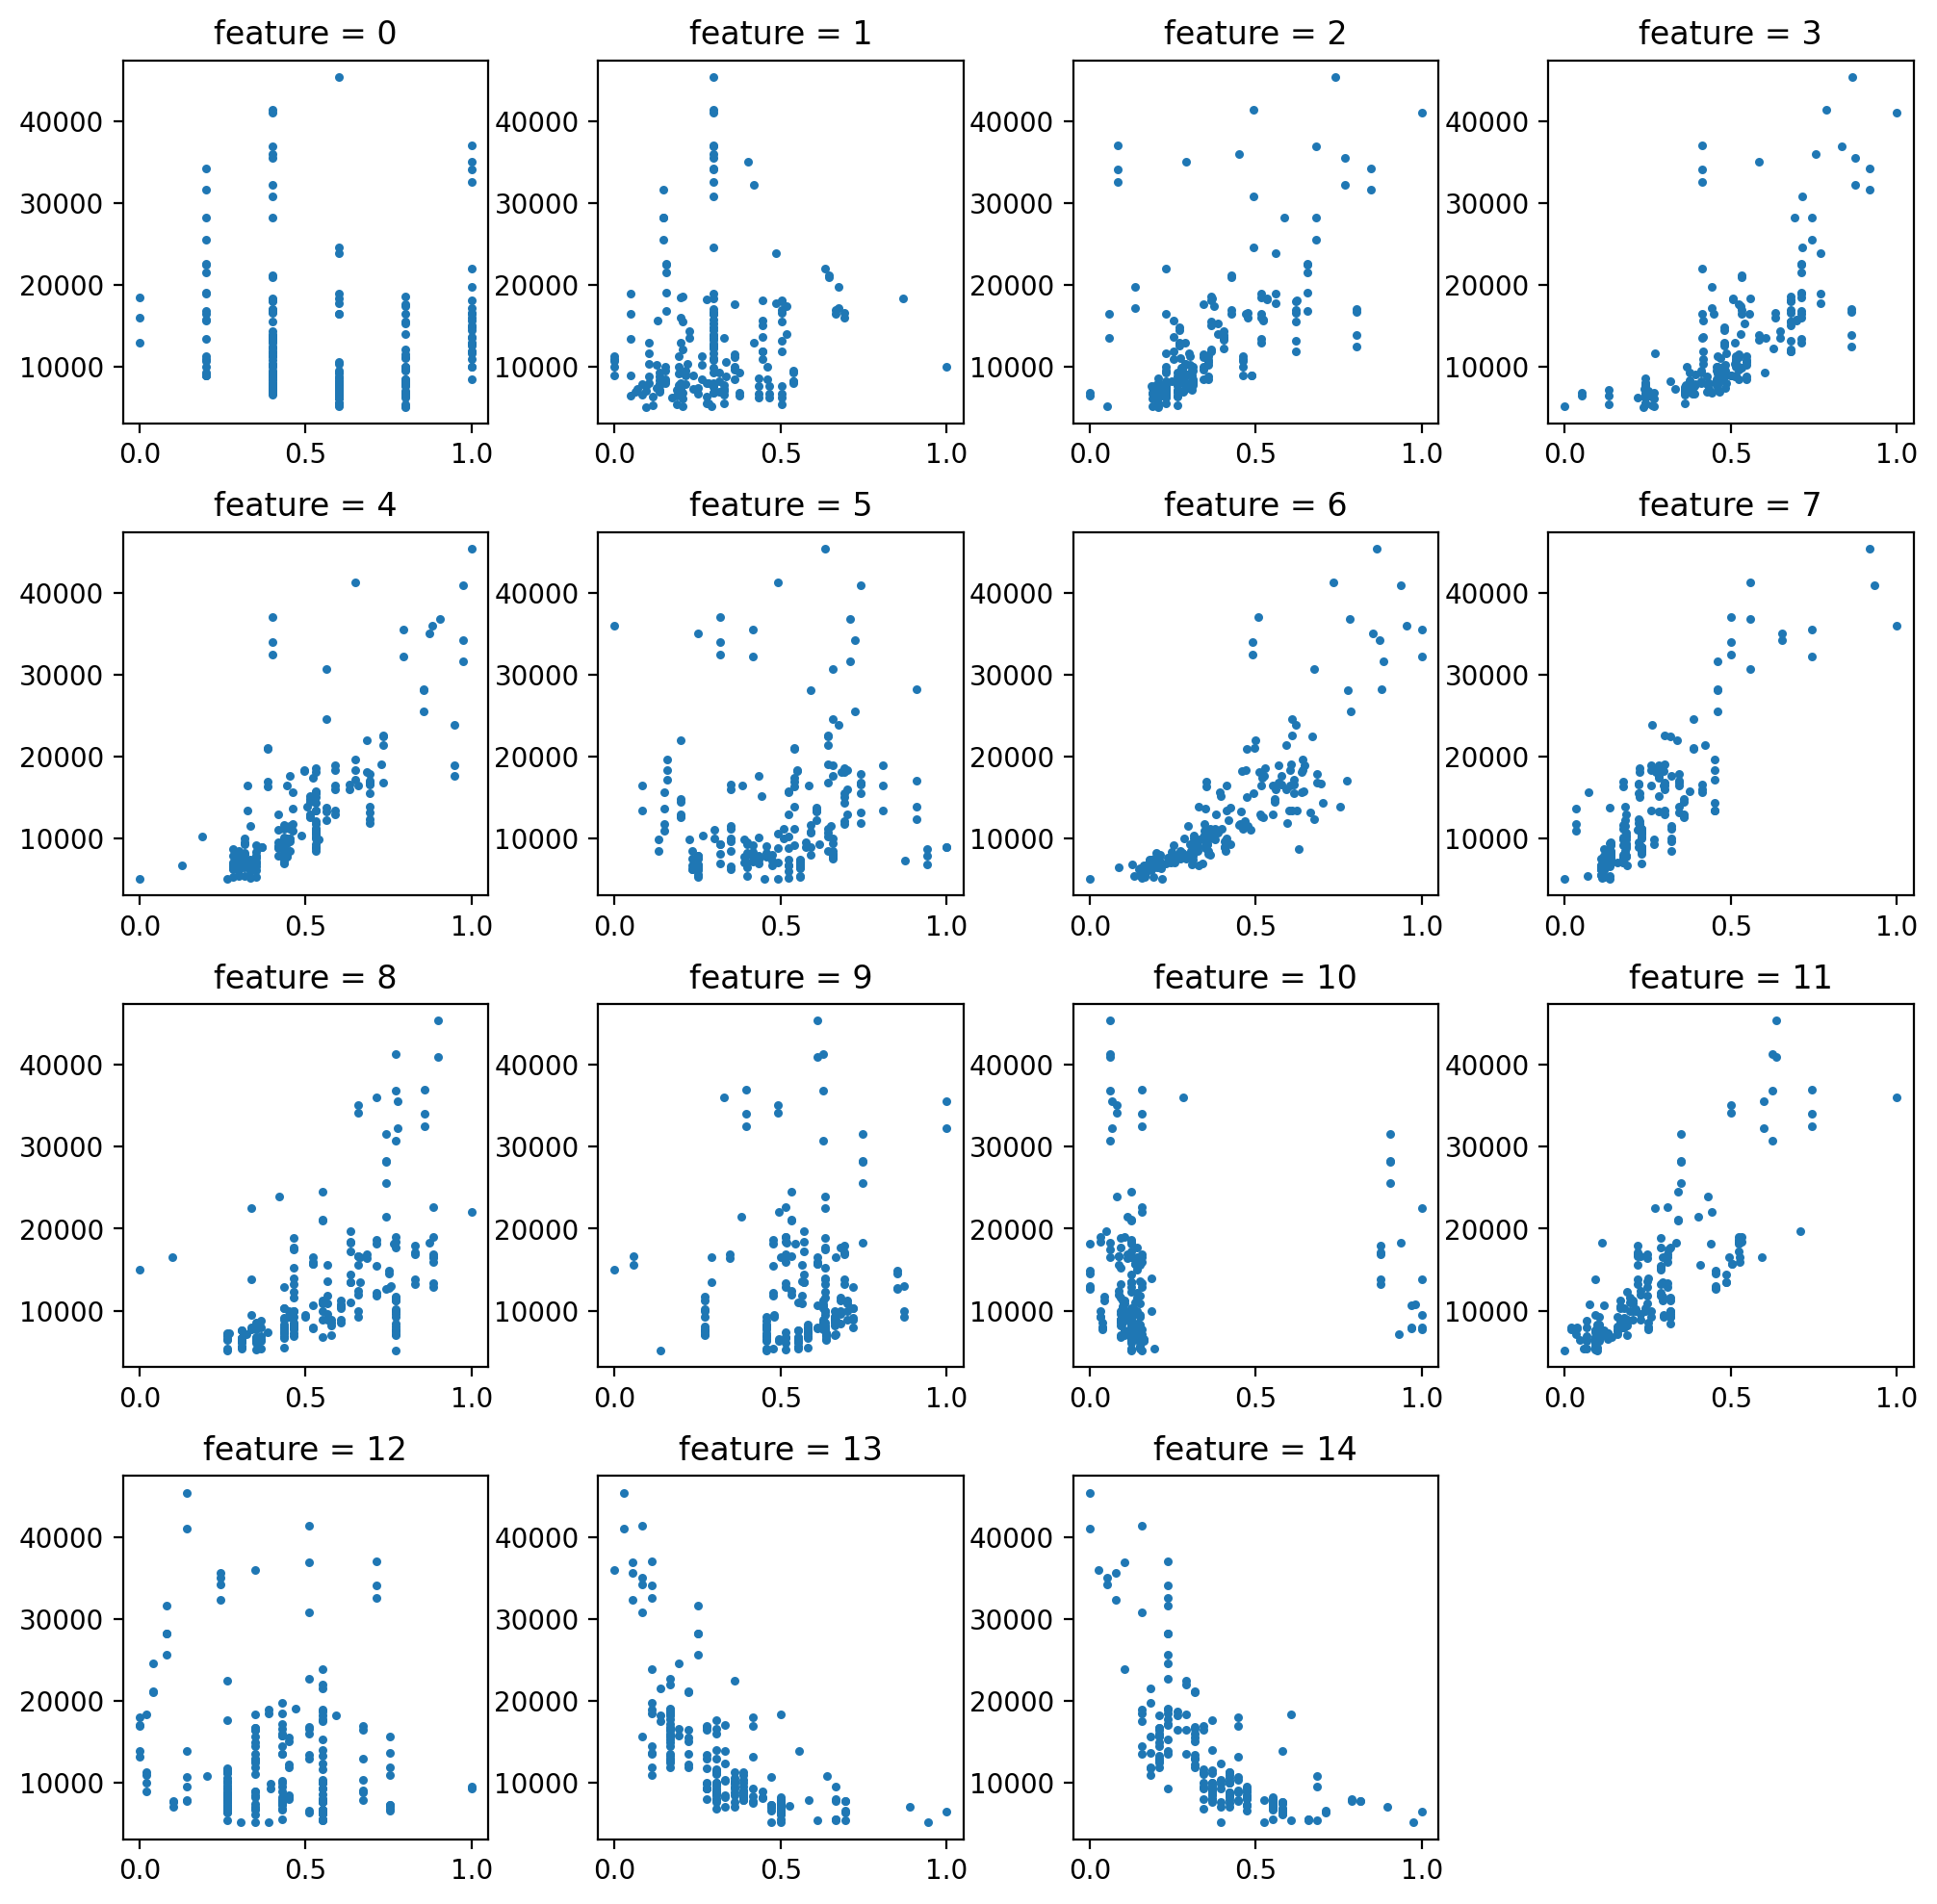

In [227]:
gs = gridspec.GridSpec(4, 4, figure=fig, hspace=0.3, wspace=0.3)
fig = plt.figure(figsize=(12, 12), dpi=200)

for feature, grd in zip(X.columns[:X_real.shape[1] - 1],
                        itertools.product([0, 1, 2, 3], repeat=2)):
    ax = plt.subplot(gs[grd[0], grd[1]])
    ax.scatter(X[[feature]], y, s=5)
    plt.title(f"feature = {feature}")

plt.show()

**Добавление полиномиальных признаков**

In [235]:
nonlinear_features = [2, 3, 6, 11, 13, 14]
if len(X.columns) == 66:
    X = pd.concat([X, X[[2]]**2], axis=1, ignore_index=True)
    X = pd.concat([X, X[[3]]**2], axis=1, ignore_index=True)
    X = pd.concat([X, X[[6]]**2], axis=1, ignore_index=True)
    X = pd.concat([X, X[[11]]**2], axis=1, ignore_index=True)
    X = pd.concat([X, 1 / (1 + X[[13]])**0.5], axis=1, ignore_index=True)
    X = pd.concat([X, 1 / (1 + X[[14]])**0.5], axis=1, ignore_index=True)
X

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,1.0,0.0,0.0,0.003400,0.170927,0.169062,0.086667,0.904534,0.880631
1,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,1.0,0.0,0.0,0.003400,0.170927,0.169062,0.086667,0.904534,0.880631
2,0.6,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,1.0,0.0,0.0,0.053048,0.201829,0.268162,0.245349,0.925820,0.889757
3,0.8,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,1.0,0.0,0.0,0.148102,0.280742,0.108455,0.063674,0.875190,0.854850
4,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,1.0,0.0,0.0,0.139262,0.280742,0.268564,0.098022,0.937043,0.929320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.2,0.157068,0.655977,0.711940,0.735043,0.641667,0.567882,0.301887,0.885714,0.514286,...,0.0,1.0,0.0,0.0,0.430305,0.506859,0.322490,0.095117,0.884652,0.871780
197,0.2,0.157068,0.655977,0.711940,0.726496,0.641667,0.605508,0.301887,0.885714,0.514286,...,0.0,1.0,0.0,0.0,0.430305,0.506859,0.366640,0.273910,0.925820,0.899172
198,0.2,0.157068,0.655977,0.711940,0.735043,0.641667,0.591156,0.422642,0.742857,0.380952,...,0.0,1.0,0.0,0.0,0.430305,0.506859,0.349465,0.161499,0.937043,0.918937
199,0.2,0.157068,0.655977,0.711940,0.735043,0.641667,0.670675,0.316981,0.335714,0.633333,...,0.0,0.0,0.0,0.0,0.430305,0.506859,0.449805,0.073456,0.857143,0.880631


**Разделение выборки на обучающую и тестовую**

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [231]:
loss = MSELoss()
linreg = LinearRegression(loss)
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [232]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f'MSE in the train data: {mean_squared_error(y_train, linreg.predict(X_train)):.2e}')
print(f'MSE in the test data: {mean_squared_error(y_test, y_pred):.2e}')

MSE in the train data: 1.38e+06
MSE in the test data: 8.32e+06


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [236]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        return np.linalg.norm(X @ w - y) ** 2 / len(y) + self.coef * np.linalg.norm(w[:-1]) ** 2

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        w[-1] = w[-1] * 0
        return 2 * X.T @ (X @ w - y) / len(y) + 2 * self.coef * w

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [237]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

[]

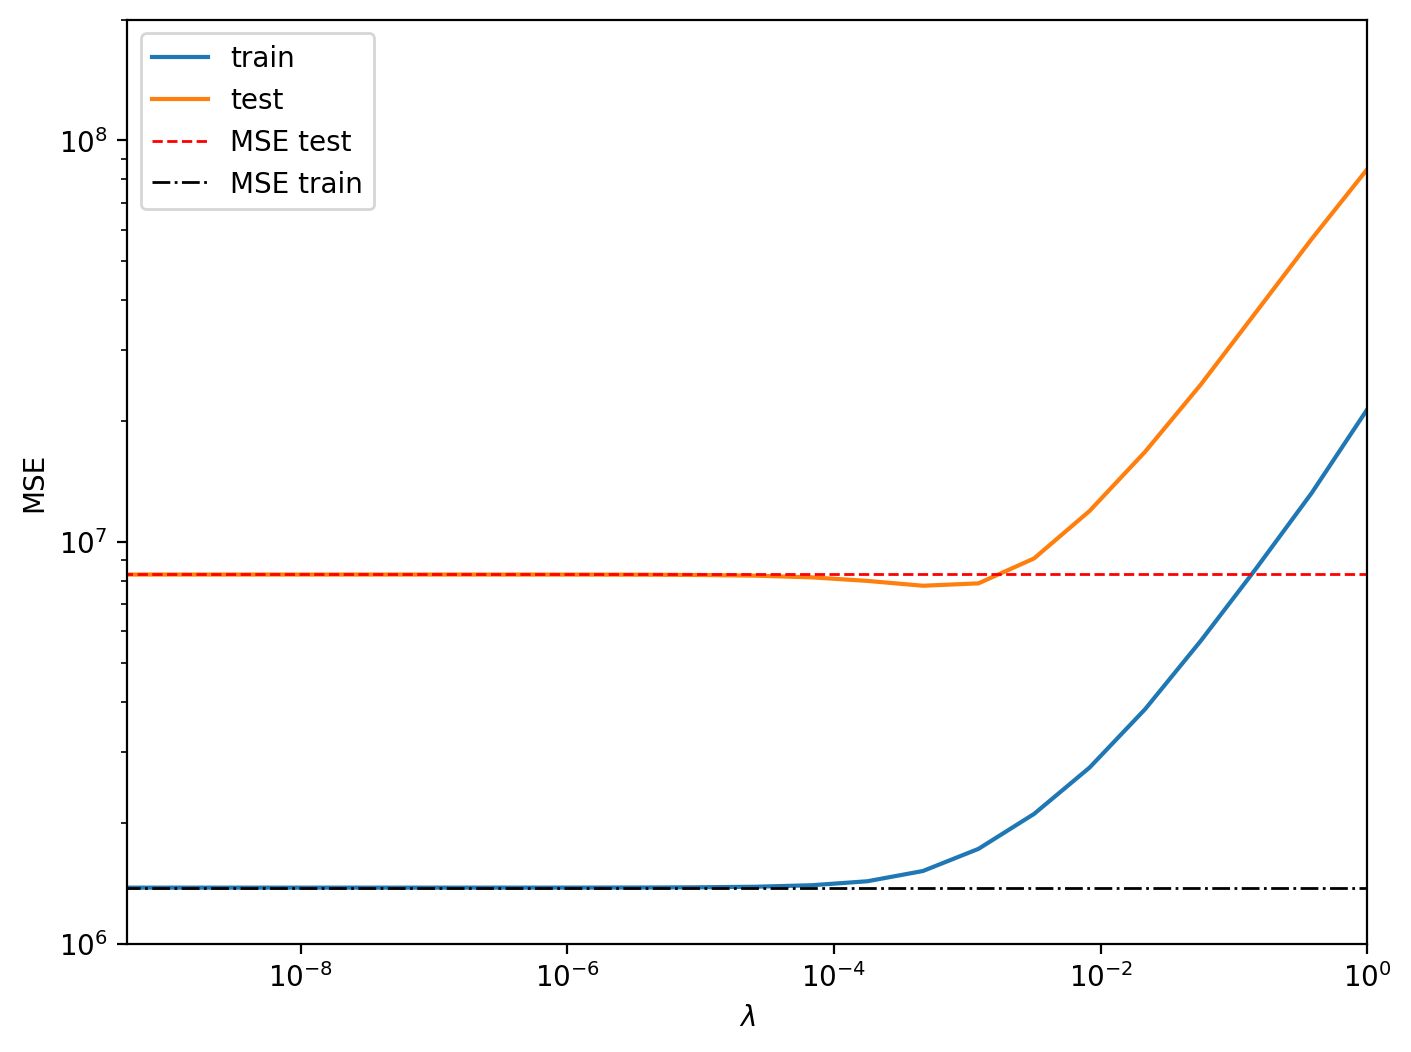

In [241]:
lambda_list = np.logspace(-10, 0, 25)
MSE_train_regularized = np.zeros(25)
MSE_test_regularized = np.zeros(25)

MSE_train = mean_squared_error(y_train, linreg.predict(X_train))
MSE_test = mean_squared_error(y_test, linreg.predict(X_test))

line_test = mlines.Line2D([1e-10, 1], [MSE_test, MSE_test], color='red',
                          linestyle='--', label='MSE test', linewidth=1)
line_train = mlines.Line2D([1e-10, 1], [MSE_train, MSE_train], color='black',
                           linestyle='-.', label='MSE train', linewidth=1)

for i, l in enumerate(lambda_list):
    lossL2 = MSEL2Loss(l)
    ridgereg = LinearRegression(lossL2)
    ridgereg.fit(X_train, y_train)
    MSE_train_regularized[i] = mean_squared_error(y_train, ridgereg.predict(X_train))
    MSE_test_regularized[i] = mean_squared_error(y_test, ridgereg.predict(X_test))

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))
fig.set_dpi(200)
ax.plot(lambda_list, MSE_train_regularized, label='train')
ax.plot(lambda_list, MSE_test_regularized, label='test')
ax.set_xlim(5 * 1e-10, 1)
ax.set_ylim(1e6, 2 * 1e8)
ax.add_line(line_test)
ax.add_line(line_train)
ax.semilogx()
ax.semilogy()
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.plot()

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [239]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def Huber_loss(self, z: np.ndarray, eps: float | int) -> float | int:
        mask = np.abs(z) < eps
        result = np.zeros_like(z)
        result[mask] = 0.5 * z[mask]**2
        result[~mask] = eps(np.abs(z[~mask]) - 0.5 * eps)
        return result.mean()
    
    def grad_Huber_loss(self, z: np.ndarray, eps: float | int) -> np.ndarray:
        mask = np.abs(z) < eps
        result = np.zeros_like(z)
        result[mask] = z[mask]
        result[~mask] = eps * np.sign(z[~mask])
        return result

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        return np.sum(self.Huber_loss(X @ w - y, self.eps)) / len(y)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return np.sum(X.T @ self.grad_Huber_loss(X @ w - y, self.eps))
        


**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [240]:
Huber_loss = HuberLoss(1e-2)
MSE_loss = MSELoss()

linreg_mse = LinearRegression(MSE_loss)
linreg_mse.fit(X_train, y_train)

linreg_huber = LinearRegression(Huber_loss)
linreg_huber.fit(X_train, y_train)

y_pred_mse = linreg_mse.predict(X_test)
y_predict_huber = linreg_huber.predict(X_test)

print(f'MSE для линейной регресси с MSE на обучающей выборке: {mean_squared_error(y_train, linreg_mse.predict(X_train)):.2e}')
print(f'MSE для линейной регресси с MSE на тестовой выборке: {mean_squared_error(y_test, linreg_mse.predict(X_test)):.2e}', end='\n\n')

print(f'MSE для линейной регресси с Huber Loss на обучающей выборке: {mean_squared_error(y_train, linreg_huber.predict(X_train)):.2e}')
print(f'MSE для линейной регресси с Huber Loss на тестовой выборке: {mean_squared_error(y_test, linreg_huber.predict(X_test)):.2e}')

MSE для линейной регресси с MSE на обучающей выборке: 1.38e+06
MSE для линейной регресси с MSE на тестовой выборке: 8.32e+06

MSE для линейной регресси с Huber Loss на обучающей выборке: 3.75e+07
MSE для линейной регресси с Huber Loss на тестовой выборке: 1.21e+08
